### Librerie


In [1]:
import os
import keras
import matplotlib.style as style
import numpy as np
from PIL import Image

from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.callbacks import Callback
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Input
from keras.models import Model
from keras.preprocessing import image as image_utils
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from keras import models, layers
import tensorflow as tf 

from random import randint
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # Plotting
import tables #gestione di set di dati gerarchici

#style.use('seaborn-whitegrid')


### Constanti


In [2]:
pathDataset='../../assets/dataset/'
pathSaveModel='../../assets/models/'
epoche=3

### Check dataset

1. Costruiamo un dizionario 'label' per memorizzare i nomi dei gesti che andremo ad indentificare
2. Costruiamo un dizionario 'reverseLabel' per memorizzare a quale gesto è associato un determinato identificatore
   // Label inserite all'interno del dataset nella prima cartella 00 che usero per i tutti i test


In [3]:
label = dict()
reverseLabel = dict()
count = 0
for j in os.listdir(pathDataset + '/00'):
    if not j.startswith('.'):
        label[j] = count
        reverseLabel[count] = j
        count = count + 1

print("Label=")
print(label)
print("ReverseLabel=")
print(reverseLabel)


Label=
{'05_thumb': 0, '08_palm_moved': 1, '02_l': 2, '01_palm': 3, '07_ok': 4, '10_down': 5, '06_index': 6, '09_c': 7, '03_fist': 8, '04_fist_moved': 9}
ReverseLabel=
{0: '05_thumb', 1: '08_palm_moved', 2: '02_l', 3: '01_palm', 4: '07_ok', 5: '10_down', 6: '06_index', 7: '09_c', 8: '03_fist', 9: '04_fist_moved'}


### Dataset

lettura dei dati memorizzandoli nell'array 'datas'
memorizziamo il classificatore numerico per ogni immagine in 'datasNum'


In [4]:

datas = []
datasNum = []

countImage = 0  # count delle immagini che ci sono nel dataset

for i in range(0, 10):  # ciclo su 10 cartelle del primo livello
    for j in os.listdir(pathDataset+'0' + str(i) + '/'):
         if not j.startswith('.'):  # evito le cartelle nascoste 
            count = 0  # conta le imagini di un gesto
            for k in os.listdir(pathDataset+'0' + str(i) + '/' + j + '/'): # ciclo le immagini
                img = Image.open(pathDataset + '0' + str(i) + '/' + j + '/' + k).convert('L') # leggo è converto in scala di grigi
                img = img.resize((224, 224))
                arr = np.array(img)
                datas.append(arr) 
                count = count + 1

            #     img = img.resize((224, 224)) ##img.resize((320, 120))#
            #     datas.append(np.array(img))
            #     count = count + 1
            
            datasNum.append(np.full((count, 1), label[j]))
            countImage = countImage + count


datasNum = np.array(datasNum)
datasNum = datasNum.reshape(countImage, 1)

print("[DEBUG] numero di immagini esaminate: " + str(countImage))

[DEBUG] numero di immagini esaminate: 20000


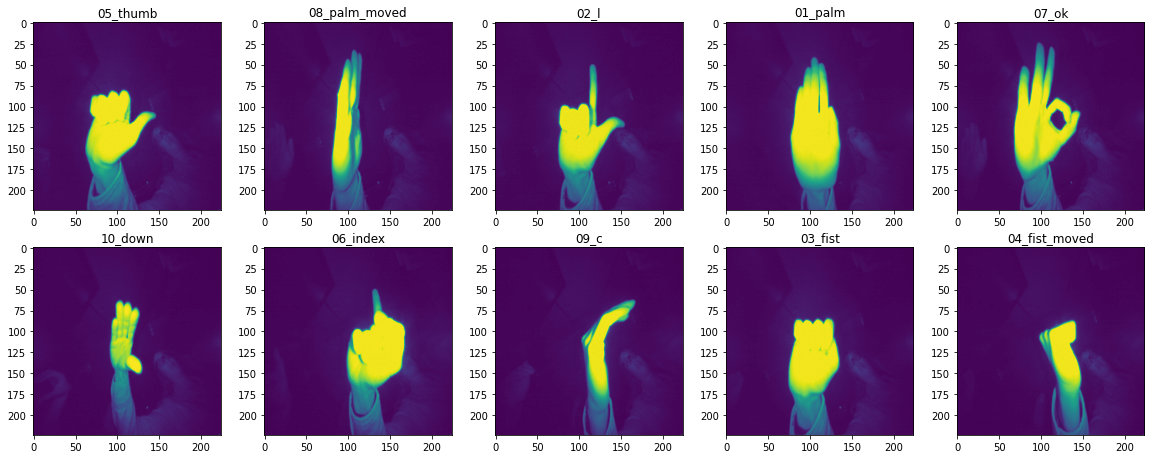

In [5]:
#Visualizzazione delle immagini
plt.figure(figsize=(20,20)) # specifying the overall grid size

for i in range(0, 10):
    # for x in range(25):
        plt.subplot(5,5,i+1)
        plt.title(reverseLabel[i])
        plt.imshow(datas[i*200])

plt.show()

In [6]:
#ridimensione del formato dell'immagini cosi da avere comprese tra 0 e 1
datas = np.array(datas, dtype = 'float32')
datas = datas.reshape(len(datas), 224, 224, 1)
datas /= 255

#conversione di datasNum in one-hot
datasNum = np.array(datasNum)
datasNum = datasNum.reshape(len(datas), 1)
datasNum = to_categorical(datasNum)

### Split dei dati tramite Skleanr 
divisione del dataset in 2 parti 80 - 20 (train) e 50 - 50 (validate)

In [7]:
xTrain, xTest, yTrain, yTest = train_test_split(datas, datasNum, test_size=0.2)
xValidation, xTest, yValidation, yTest = train_test_split(datas, datasNum, test_size=0.5)

# Modello tramite keras: 

Inzio ad aggiungere al modello di keras un filtro 5*5 con passo 2. 
Aggiungiamo una sequenza di livelli di convoluzione seguiti da un raggruppamento massimo fino a un'immagine piccola
In fine aggiungiamo uno strato di softmax con 10 neuroni

Di seguito adattiamo il modello 

In [8]:
model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), activation='relu', input_shape=(224, 224,1))) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))


model.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 110, 110, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 55, 55, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 53, 53, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 26, 26, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0

Allenamentodellarete--con10epocheiniziali--

In [9]:
history = model.fit(xTrain, yTrain, 
        epochs=epoche,
        batch_size=64, 
        verbose=1, 
        validation_data=(xValidation, yValidation))

Epoch 1/3
250/250 [==============================] - 131s 518ms/step - loss: 0.2677 - accuracy: 0.9131 - val_loss: 0.0135 - val_accuracy: 0.9962
Epoch 2/3
250/250 [==============================] - 122s 487ms/step - loss: 0.0179 - accuracy: 0.9956 - val_loss: 0.0011 - val_accuracy: 0.9996
Epoch 3/3
250/250 [==============================] - 126s 504ms/step - loss: 0.0123 - accuracy: 0.9981 - val_loss: 7.5592e-04 - val_accuracy: 0.9997


### Plot History

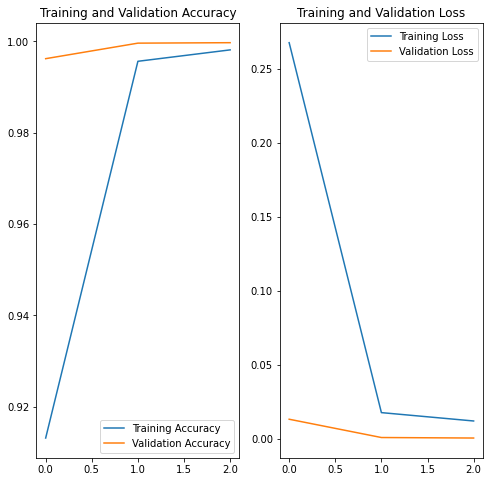

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epoche) 

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
#Preparazione della 'Matrice di convoluzione'
y_pred=model.predict(xTest) 
y_pred=np.argmax(yValidation, axis=1)
y_test=np.argmax(yTest, axis=1)
cm = confusion_matrix(y_test, y_pred)
# print(cm)

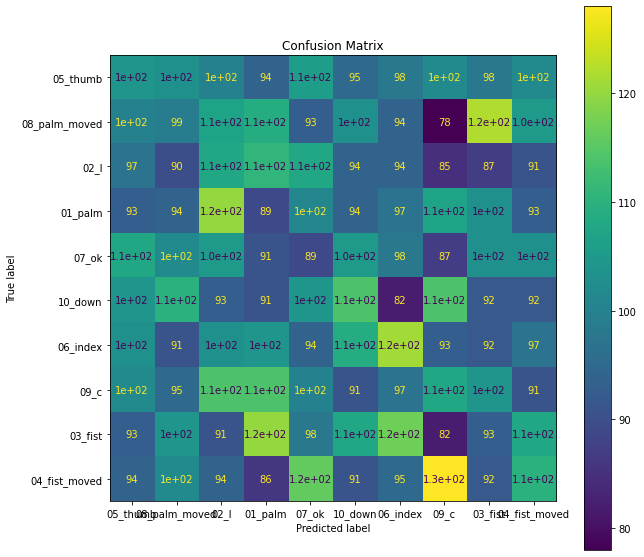

In [12]:
#Plot Matrice di convoluzione 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label)
fig, ax = plt.subplots(figsize=(10,10))
plt.title("Confusion Matrix")
disp = disp.plot(ax=ax)
plt.show()

In [13]:
# valutazione delle previsioni della rete  
valutazione = model.predict(xTest, batch_size=64) 
print(classification_report(yTest.argmax(axis=1),
                            valutazione.argmax(axis=1), 
                            target_names=label))


               precision    recall  f1-score   support

     05_thumb       1.00      1.00      1.00      1002
08_palm_moved       1.00      1.00      1.00      1010
         02_l       1.00      1.00      1.00       965
      01_palm       1.00      1.00      1.00       991
        07_ok       1.00      1.00      1.00       991
      10_down       1.00      1.00      1.00       996
     06_index       1.00      1.00      1.00      1007
         09_c       1.00      1.00      1.00      1016
      03_fist       1.00      1.00      1.00      1014
04_fist_moved       1.00      1.00      1.00      1008

     accuracy                           1.00     10000
    macro avg       1.00      1.00      1.00     10000
 weighted avg       1.00      1.00      1.00     10000



### Save Model

In [17]:
#model.save(pathSaveModel) save all
model.save(pathSaveModel+'model.h5')

# Creazione del modello con VGG16

In [38]:
# Get back the convolutional part of a VGG network trained on ImageNet
model_vgg16_conv = VGG16(
    weights='imagenet',
    include_top=False,
)
model_vgg16_conv.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
# Crezionde dellimmaginie del formato (224x224x3) per li nostro input della rete
imageInput = Input(shape=(224, 224, 3), name='imageInput')

# makes the layers non-trainable
for layer in model_vgg16_conv.layers:
    layer.trainable = False

# Uso il generatore di modello:
outputVgg16Conv = model_vgg16_conv(imageInput)

# Add the fully-connected layers 
x = Flatten(name='flatten')(outputVgg16Conv)
x = Dense(10, activation='softmax', name='predictions')(x)  # here the 2 indicates binary (3 or more is multiclass)

# Creazionde del nostro modello 
my_model = Model(imageInput, x)

# In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
my_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 imageInput (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 predictions (Dense)         (None, 10)                250890    
                                                                 
Total params: 14,965,578
Trainable params: 250,890
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# ottimizzazione del modello: 
baseModel = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
optimizer = tf.keras.optimizers.Adam() # Adam is like a gradient descent (way to find parameters)

In [ ]:
# Add top layer
x = baseModel.output
x = Flatten()(x)
x = Dropout(0.5)(x)

predictions = Dense(10, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)

# Train top layer
for layer in baseModel.layers:
    layer.trainable = False

model.compile(loss='categorical_crossentropy', 
            optimizer=optimizer, 
            metrics=['accuracy'])

callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
history = model.fit(xTrain[:500], 
        yTrain[:500], 
        epochs=4, 
        batch_size=64,
        validation_data=(xValidation[:500], yValidation[:500]),
        verbose=1
        )

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epoche) 

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#https://www.kaggle.com/code/benenharrington/hand-gesture-recognition-database-with-cnn/notebook
#perdopo:https://techvidvan.com/tutorials/hand-gesture-recognition-tensorflow-opencv/